# 📊 Julaba Trading Strategy Research & Optimization

## Objective
Analyze the current SMA crossover strategy, backtest with historical data, and find improvements through mathematical analysis and testing.

### Research Areas:
1. **Current Strategy Performance** - Backtest SMA 10/30 crossover
2. **Parameter Optimization** - Find optimal SMA periods
3. **Market Regime Detection** - Trending vs Ranging markets
4. **Filter Analysis** - RSI, ADX, Volume filters
5. **Risk-Adjusted Returns** - Sharpe ratio, max drawdown
6. **Recommendations** - Data-driven improvements

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ccxt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 200)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. Fetch Historical Data
Let's get 30 days of 1-minute OHLCV data for LINK/USDT from MEXC.

In [2]:
def fetch_ohlcv(symbol='LINK/USDT', timeframe='1m', days=7):
    """Fetch historical OHLCV data from MEXC."""
    exchange = ccxt.mexc({'enableRateLimit': True})
    
    all_data = []
    since = exchange.parse8601((datetime.utcnow() - timedelta(days=days)).isoformat())
    
    print(f"📥 Fetching {days} days of {timeframe} data for {symbol}...")
    
    while True:
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=1000)
            if not ohlcv:
                break
            all_data.extend(ohlcv)
            since = ohlcv[-1][0] + 1
            print(f"   Fetched {len(all_data)} candles...", end='\r')
            
            # Stop if we've reached current time
            if ohlcv[-1][0] > exchange.milliseconds() - 60000:
                break
        except Exception as e:
            print(f"Error: {e}")
            break
    
    df = pd.DataFrame(all_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    
    print(f"\n✅ Loaded {len(df)} candles from {df.index[0]} to {df.index[-1]}")
    return df

# Fetch data
df = fetch_ohlcv('LINK/USDT', '1m', days=7)
df.tail()

📥 Fetching 7 days of 1m data for LINK/USDT...
   Fetched 10080 candles...
✅ Loaded 10080 candles from 2026-01-01 05:46:00 to 2026-01-08 05:45:00


,open,high,low,close,volume
timestamp,,,,,
2026-01-08 05:41:00,13.44,13.44,13.42,13.42,88.48
2026-01-08 05:42:00,13.42,13.43,13.40,13.40,535.06
2026-01-08 05:43:00,13.40,13.41,13.38,13.38,240.58
2026-01-08 05:44:00,13.38,13.39,13.38,13.38,2109.52
2026-01-08 05:45:00,13.38,13.39,13.38,13.39,66.02


## 2. Define Technical Indicators

Calculate all the indicators we'll test: SMA, EMA, RSI, ADX, ATR, Bollinger Bands, and Volume indicators.

In [3]:
def calculate_indicators(df):
    """Calculate all technical indicators."""
    data = df.copy()
    
    # Simple Moving Averages
    for period in [5, 10, 20, 30, 50, 100]:
        data[f'sma_{period}'] = data['close'].rolling(period).mean()
    
    # Exponential Moving Averages
    for period in [9, 12, 21, 26]:
        data[f'ema_{period}'] = data['close'].ewm(span=period, adjust=False).mean()
    
    # RSI (Relative Strength Index)
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['rsi'] = 100 - (100 / (1 + rs))
    
    # ATR (Average True Range)
    high_low = data['high'] - data['low']
    high_close = abs(data['high'] - data['close'].shift())
    low_close = abs(data['low'] - data['close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    data['atr'] = tr.rolling(14).mean()
    
    # ADX (Average Directional Index) - Trend Strength
    plus_dm = data['high'].diff()
    minus_dm = data['low'].diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr14 = tr.rolling(14).sum()
    plus_di = 100 * (plus_dm.rolling(14).sum() / tr14)
    minus_di = 100 * (abs(minus_dm).rolling(14).sum() / tr14)
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    data['adx'] = dx.rolling(14).mean()
    
    # Bollinger Bands
    data['bb_mid'] = data['close'].rolling(20).mean()
    bb_std = data['close'].rolling(20).std()
    data['bb_upper'] = data['bb_mid'] + (2 * bb_std)
    data['bb_lower'] = data['bb_mid'] - (2 * bb_std)
    data['bb_width'] = (data['bb_upper'] - data['bb_lower']) / data['bb_mid']
    
    # Volume indicators
    data['volume_sma'] = data['volume'].rolling(20).mean()
    data['volume_ratio'] = data['volume'] / data['volume_sma']
    
    # Price momentum
    data['momentum'] = data['close'].pct_change(10) * 100
    
    return data

# Calculate all indicators
df = calculate_indicators(df)
print(f"✅ Calculated indicators. Columns: {list(df.columns)}")
df[['close', 'sma_10', 'sma_30', 'rsi', 'adx', 'atr']].tail(10)

✅ Calculated indicators. Columns: ['open', 'high', 'low', 'close', 'volume', 'sma_5', 'sma_10', 'sma_20', 'sma_30', 'sma_50', 'sma_100', 'ema_9', 'ema_12', 'ema_21', 'ema_26', 'rsi', 'atr', 'adx', 'bb_mid', 'bb_upper', 'bb_lower', 'bb_width', 'volume_sma', 'volume_ratio', 'momentum']


,close,sma_10,sma_30,rsi,adx,atr
timestamp,,,,,,
2026-01-08 05:36:00,13.43,13.436,13.445667,33.333333,16.326531,0.015000
2026-01-08 05:37:00,13.43,13.436,13.444333,36.363636,17.687075,0.015000
2026-01-08 05:38:00,13.44,13.436,13.443667,41.666667,16.734694,0.015714
2026-01-08 05:39:00,13.45,13.438,13.443333,54.545455,16.507937,0.015714
2026-01-08 05:40:00,13.44,13.439,13.443000,45.454545,16.281179,0.015714
2026-01-08 05:41:00,13.42,13.438,13.442333,45.454545,15.260771,0.015714
2026-01-08 05:42:00,13.40,13.433,13.440667,33.333333,15.430839,0.017143
2026-01-08 05:43:00,13.38,13.427,13.439000,30.769231,16.058782,0.017857
2026-01-08 05:44:00,13.38,13.421,13.437333,30.769231,16.686726,0.017143


## 3. Backtesting Framework

Create a robust backtesting engine that simulates the Julaba trading strategy with configurable parameters.

In [4]:
class Backtester:
    """
    Backtesting engine for trading strategies.
    Implements the same logic as Julaba bot.
    """
    
    def __init__(self, 
                 initial_balance=10000,
                 risk_pct=0.02,
                 atr_mult=2.0,
                 tp1_r=1.0, tp2_r=2.0, tp3_r=3.0,
                 tp1_pct=0.4, tp2_pct=0.3, tp3_pct=0.3,
                 commission=0.001):  # 0.1% commission
        
        self.initial_balance = initial_balance
        self.risk_pct = risk_pct
        self.atr_mult = atr_mult
        self.tp1_r, self.tp2_r, self.tp3_r = tp1_r, tp2_r, tp3_r
        self.tp1_pct, self.tp2_pct, self.tp3_pct = tp1_pct, tp2_pct, tp3_pct
        self.commission = commission
        
    def run(self, df, signals):
        """
        Run backtest with given signals.
        
        Args:
            df: OHLCV DataFrame with 'atr' column
            signals: Series with 1 (long), -1 (short), 0 (no signal)
            
        Returns:
            dict with results and trade history
        """
        balance = self.initial_balance
        position = None
        trades = []
        equity_curve = [balance]
        
        for i in range(len(df)):
            price = df['close'].iloc[i]
            high = df['high'].iloc[i]
            low = df['low'].iloc[i]
            atr = df['atr'].iloc[i]
            signal = signals.iloc[i] if i < len(signals) else 0
            
            # Skip if no ATR data
            if pd.isna(atr):
                equity_curve.append(balance)
                continue
            
            # Manage existing position
            if position:
                # Check stop loss
                sl_hit = (position['side'] == 'long' and low <= position['stop_loss']) or \
                         (position['side'] == 'short' and high >= position['stop_loss'])
                
                if sl_hit:
                    exit_price = position['stop_loss']
                    pnl = self._calculate_pnl(position, exit_price, position['remaining'])
                    balance += pnl - (abs(pnl) * self.commission)
                    trades.append({**position, 'exit_price': exit_price, 'pnl': pnl, 'exit_reason': 'SL'})
                    position = None
                else:
                    # Check take profits
                    position, tp_pnl = self._check_tps(position, high, low, price)
                    balance += tp_pnl
                    
                    # Check if position fully closed
                    if position and position['remaining'] <= 0:
                        trades.append({**position, 'exit_price': price, 'pnl': position.get('total_pnl', 0), 'exit_reason': 'TP3'})
                        position = None
            
            # Open new position if signal and no position
            if signal != 0 and position is None:
                side = 'long' if signal == 1 else 'short'
                
                # Calculate position parameters
                if side == 'long':
                    stop_loss = price - (atr * self.atr_mult)
                else:
                    stop_loss = price + (atr * self.atr_mult)
                
                risk_per_unit = abs(price - stop_loss)
                risk_amount = balance * self.risk_pct
                size = risk_amount / risk_per_unit
                
                # Calculate take profits
                r_value = risk_per_unit
                if side == 'long':
                    tp1 = price + (r_value * self.tp1_r)
                    tp2 = price + (r_value * self.tp2_r)
                    tp3 = price + (r_value * self.tp3_r)
                else:
                    tp1 = price - (r_value * self.tp1_r)
                    tp2 = price - (r_value * self.tp2_r)
                    tp3 = price - (r_value * self.tp3_r)
                
                # Deduct commission
                balance -= size * price * self.commission
                
                position = {
                    'side': side,
                    'entry_price': price,
                    'size': size,
                    'stop_loss': stop_loss,
                    'tp1': tp1, 'tp2': tp2, 'tp3': tp3,
                    'tp1_hit': False, 'tp2_hit': False, 'tp3_hit': False,
                    'remaining': 1.0,
                    'total_pnl': 0,
                    'entry_time': df.index[i]
                }
            
            equity_curve.append(balance)
        
        # Close any remaining position at last price
        if position:
            final_price = df['close'].iloc[-1]
            pnl = self._calculate_pnl(position, final_price, position['remaining'])
            balance += pnl
            trades.append({**position, 'exit_price': final_price, 'pnl': pnl, 'exit_reason': 'EOD'})
        
        return self._calculate_metrics(trades, equity_curve, df)
    
    def _calculate_pnl(self, pos, exit_price, portion):
        """Calculate P&L for a position portion."""
        if pos['side'] == 'long':
            return (exit_price - pos['entry_price']) * pos['size'] * portion
        else:
            return (pos['entry_price'] - exit_price) * pos['size'] * portion
    
    def _check_tps(self, pos, high, low, close):
        """Check and handle take profits."""
        total_pnl = 0
        
        # TP1
        if not pos['tp1_hit']:
            tp1_hit = (pos['side'] == 'long' and high >= pos['tp1']) or \
                      (pos['side'] == 'short' and low <= pos['tp1'])
            if tp1_hit:
                pnl = self._calculate_pnl(pos, pos['tp1'], self.tp1_pct)
                total_pnl += pnl - (abs(pnl) * self.commission)
                pos['tp1_hit'] = True
                pos['remaining'] -= self.tp1_pct
                pos['total_pnl'] = pos.get('total_pnl', 0) + pnl
        
        # TP2
        if pos['tp1_hit'] and not pos['tp2_hit']:
            tp2_hit = (pos['side'] == 'long' and high >= pos['tp2']) or \
                      (pos['side'] == 'short' and low <= pos['tp2'])
            if tp2_hit:
                pnl = self._calculate_pnl(pos, pos['tp2'], self.tp2_pct)
                total_pnl += pnl - (abs(pnl) * self.commission)
                pos['tp2_hit'] = True
                pos['remaining'] -= self.tp2_pct
                pos['total_pnl'] = pos.get('total_pnl', 0) + pnl
        
        # TP3
        if pos['tp2_hit'] and not pos['tp3_hit']:
            tp3_hit = (pos['side'] == 'long' and high >= pos['tp3']) or \
                      (pos['side'] == 'short' and low <= pos['tp3'])
            if tp3_hit:
                pnl = self._calculate_pnl(pos, pos['tp3'], self.tp3_pct)
                total_pnl += pnl - (abs(pnl) * self.commission)
                pos['tp3_hit'] = True
                pos['remaining'] -= self.tp3_pct
                pos['total_pnl'] = pos.get('total_pnl', 0) + pnl
        
        return pos, total_pnl
    
    def _calculate_metrics(self, trades, equity_curve, df):
        """Calculate performance metrics."""
        equity = np.array(equity_curve)
        returns = np.diff(equity) / equity[:-1]
        
        # Basic metrics
        total_trades = len(trades)
        if total_trades == 0:
            return {'total_trades': 0, 'message': 'No trades executed'}
        
        winning_trades = sum(1 for t in trades if t['pnl'] > 0)
        losing_trades = sum(1 for t in trades if t['pnl'] <= 0)
        
        gross_profit = sum(t['pnl'] for t in trades if t['pnl'] > 0)
        gross_loss = abs(sum(t['pnl'] for t in trades if t['pnl'] < 0))
        
        # Calculate max drawdown
        peak = equity[0]
        max_dd = 0
        for val in equity:
            if val > peak:
                peak = val
            dd = (peak - val) / peak
            if dd > max_dd:
                max_dd = dd
        
        # Sharpe ratio (annualized, assuming 1-min bars)
        if len(returns) > 0 and np.std(returns) > 0:
            sharpe = np.mean(returns) / np.std(returns) * np.sqrt(525600)  # minutes per year
        else:
            sharpe = 0
        
        return {
            'total_trades': total_trades,
            'winning_trades': winning_trades,
            'losing_trades': losing_trades,
            'win_rate': winning_trades / total_trades if total_trades > 0 else 0,
            'gross_profit': gross_profit,
            'gross_loss': gross_loss,
            'net_profit': gross_profit - gross_loss,
            'profit_factor': gross_profit / gross_loss if gross_loss > 0 else float('inf'),
            'avg_win': gross_profit / winning_trades if winning_trades > 0 else 0,
            'avg_loss': gross_loss / losing_trades if losing_trades > 0 else 0,
            'max_drawdown': max_dd * 100,
            'sharpe_ratio': sharpe,
            'final_balance': equity[-1],
            'total_return': (equity[-1] - self.initial_balance) / self.initial_balance * 100,
            'equity_curve': equity,
            'trades': trades
        }

print("✅ Backtester class defined")

✅ Backtester class defined


## 4. Test Current Strategy (SMA 10/30 Crossover)

Backtest the current Julaba strategy to establish a baseline.

In [5]:
def generate_sma_signals(df, short_period=10, long_period=30):
    """Generate SMA crossover signals."""
    signals = pd.Series(0, index=df.index)
    
    sma_short = df['close'].rolling(short_period).mean()
    sma_long = df['close'].rolling(long_period).mean()
    
    # Long when short crosses above long
    long_signal = (sma_short > sma_long) & (sma_short.shift(1) <= sma_long.shift(1))
    signals[long_signal] = 1
    
    # Short when short crosses below long
    short_signal = (sma_short < sma_long) & (sma_short.shift(1) >= sma_long.shift(1))
    signals[short_signal] = -1
    
    return signals

# Generate signals with current strategy
signals_baseline = generate_sma_signals(df, 10, 30)
print(f"📊 Generated signals: {(signals_baseline == 1).sum()} longs, {(signals_baseline == -1).sum()} shorts")

# Run backtest
backtester = Backtester(initial_balance=10000)
results_baseline = backtester.run(df, signals_baseline)

# Display results
print("\n" + "="*60)
print("📈 BASELINE STRATEGY: SMA 10/30 Crossover")
print("="*60)
print(f"Total Trades:      {results_baseline['total_trades']}")
print(f"Win Rate:          {results_baseline['win_rate']:.1%}")
print(f"Profit Factor:     {results_baseline['profit_factor']:.2f}")
print(f"Net Profit:        ${results_baseline['net_profit']:.2f}")
print(f"Total Return:      {results_baseline['total_return']:.2f}%")
print(f"Max Drawdown:      {results_baseline['max_drawdown']:.2f}%")
print(f"Sharpe Ratio:      {results_baseline['sharpe_ratio']:.2f}")
print(f"Avg Win:           ${results_baseline['avg_win']:.2f}")
print(f"Avg Loss:          ${results_baseline['avg_loss']:.2f}")
print(f"Final Balance:     ${results_baseline['final_balance']:.2f}")

📊 Generated signals: 205 longs, 206 shorts

📈 BASELINE STRATEGY: SMA 10/30 Crossover
Total Trades:      138
Win Rate:          21.0%
Profit Factor:     0.60
Net Profit:        $-4167.74
Total Return:      -68.38%
Max Drawdown:      68.38%
Sharpe Ratio:      -33.07
Avg Win:           $218.90
Avg Loss:          $96.47
Final Balance:     $3161.81


## 5. Parameter Optimization - Find Best SMA Periods

Test different SMA period combinations to find optimal parameters.

In [6]:
# Test different SMA combinations
short_periods = [5, 8, 10, 12, 15, 20]
long_periods = [20, 30, 40, 50, 60, 100]

optimization_results = []

print("🔍 Testing SMA combinations...")
for short in short_periods:
    for long in long_periods:
        if short >= long:
            continue
        
        signals = generate_sma_signals(df, short, long)
        results = backtester.run(df, signals)
        
        optimization_results.append({
            'short': short,
            'long': long,
            'trades': results['total_trades'],
            'win_rate': results['win_rate'],
            'profit_factor': results['profit_factor'] if results['profit_factor'] != float('inf') else 0,
            'net_profit': results['net_profit'],
            'max_dd': results['max_drawdown'],
            'sharpe': results['sharpe_ratio'],
            'return': results['total_return']
        })

# Convert to DataFrame and sort by net profit
opt_df = pd.DataFrame(optimization_results)
opt_df = opt_df.sort_values('net_profit', ascending=False)

print("\n📊 TOP 10 SMA COMBINATIONS BY NET PROFIT:")
print("="*80)
display_cols = ['short', 'long', 'trades', 'win_rate', 'profit_factor', 'net_profit', 'max_dd', 'sharpe']
print(opt_df[display_cols].head(10).to_string(index=False))

# Best parameters
best = opt_df.iloc[0]
print(f"\n🏆 BEST: SMA {int(best['short'])}/{int(best['long'])} - Net Profit: ${best['net_profit']:.2f}, Win Rate: {best['win_rate']:.1%}")

🔍 Testing SMA combinations...

📊 TOP 10 SMA COMBINATIONS BY NET PROFIT:
 short  long  trades  win_rate  profit_factor   net_profit    max_dd     sharpe
    15    40     117  0.324786       1.067795   694.619686 36.915427  -8.674046
     5   100      91  0.296703       0.990991   -73.465211 33.845633 -10.749319
    15    20     138  0.297101       0.977233  -269.021219 38.748755 -11.960283
    20    50     114  0.315789       0.969588  -309.966787 44.491523 -16.548906
    15    30     120  0.316667       0.903517  -893.595380 51.628960 -18.053183
    15    60     106  0.292453       0.892453  -961.395615 48.860753 -16.652242
    20    60     109  0.284404       0.871767 -1209.239972 49.855163 -18.948649
    12    40     132  0.287879       0.881064 -1303.164438 50.045396 -18.190598
     5    20     123  0.276423       0.852832 -1628.173104 56.044798 -22.099869
    12    20     140  0.278571       0.849237 -1724.278144 57.015343 -20.886557

🏆 BEST: SMA 15/40 - Net Profit: $694.62, Win Ra

## 6. Market Regime Detection

Analyze when the strategy works best: trending vs ranging markets using ADX indicator.

In [7]:
# Classify market regimes based on ADX
# ADX > 25 = Trending, ADX < 20 = Ranging
df['regime'] = 'neutral'
df.loc[df['adx'] > 25, 'regime'] = 'trending'
df.loc[df['adx'] < 20, 'regime'] = 'ranging'

# Analyze regime distribution
regime_counts = df['regime'].value_counts()
print("📊 MARKET REGIME DISTRIBUTION:")
print("="*40)
for regime, count in regime_counts.items():
    pct = count / len(df) * 100
    print(f"  {regime.capitalize():12} {count:6} bars ({pct:.1f}%)")

# Test strategy in different regimes
print("\n📈 STRATEGY PERFORMANCE BY MARKET REGIME:")
print("="*60)

for regime in ['trending', 'ranging', 'neutral']:
    # Filter data for this regime
    regime_mask = df['regime'] == regime
    df_regime = df[regime_mask].copy()
    
    if len(df_regime) < 100:
        print(f"\n{regime.upper()}: Not enough data")
        continue
    
    # Generate signals and backtest
    signals = generate_sma_signals(df_regime, 10, 30)
    results = backtester.run(df_regime, signals)
    
    print(f"\n{regime.upper()} MARKET (ADX {'> 25' if regime == 'trending' else '< 20' if regime == 'ranging' else '20-25'}):")
    print(f"  Trades: {results['total_trades']}, Win Rate: {results['win_rate']:.1%}, "
          f"Net Profit: ${results['net_profit']:.2f}, Profit Factor: {results['profit_factor']:.2f}")

📊 MARKET REGIME DISTRIBUTION:
  Trending       7383 bars (73.2%)
  Ranging        1584 bars (15.7%)
  Neutral        1113 bars (11.0%)

📈 STRATEGY PERFORMANCE BY MARKET REGIME:

TRENDING MARKET (ADX > 25):
  Trades: 114, Win Rate: 28.1%, Net Profit: $-1101.64, Profit Factor: 0.89

RANGING MARKET (ADX < 20):
  Trades: 43, Win Rate: 20.9%, Net Profit: $-1705.91, Profit Factor: 0.63

NEUTRAL MARKET (ADX 20-25):
  Trades: 33, Win Rate: 30.3%, Net Profit: $-250.35, Profit Factor: 0.93


## 7. Filter Testing - RSI, Volume, ADX

Test adding filters to reduce false signals and improve win rate.

In [8]:
def generate_filtered_signals(df, short_period=10, long_period=30, 
                               use_rsi=False, use_adx=False, use_volume=False):
    """Generate SMA crossover signals with optional filters."""
    signals = pd.Series(0, index=df.index)
    
    sma_short = df['close'].rolling(short_period).mean()
    sma_long = df['close'].rolling(long_period).mean()
    
    # Base crossover signals
    long_cross = (sma_short > sma_long) & (sma_short.shift(1) <= sma_long.shift(1))
    short_cross = (sma_short < sma_long) & (sma_short.shift(1) >= sma_long.shift(1))
    
    # Apply filters
    long_filter = pd.Series(True, index=df.index)
    short_filter = pd.Series(True, index=df.index)
    
    if use_rsi:
        # Long only if RSI < 70 (not overbought)
        # Short only if RSI > 30 (not oversold)
        long_filter &= df['rsi'] < 70
        short_filter &= df['rsi'] > 30
    
    if use_adx:
        # Only trade when ADX > 20 (trend present)
        trend_filter = df['adx'] > 20
        long_filter &= trend_filter
        short_filter &= trend_filter
    
    if use_volume:
        # Only trade when volume > average (confirmation)
        vol_filter = df['volume_ratio'] > 1.0
        long_filter &= vol_filter
        short_filter &= vol_filter
    
    signals[long_cross & long_filter] = 1
    signals[short_cross & short_filter] = -1
    
    return signals

# Test different filter combinations
filter_tests = [
    {'name': 'Baseline (No Filters)', 'rsi': False, 'adx': False, 'vol': False},
    {'name': '+ RSI Filter', 'rsi': True, 'adx': False, 'vol': False},
    {'name': '+ ADX Filter', 'rsi': False, 'adx': True, 'vol': False},
    {'name': '+ Volume Filter', 'rsi': False, 'adx': False, 'vol': True},
    {'name': '+ RSI + ADX', 'rsi': True, 'adx': True, 'vol': False},
    {'name': '+ RSI + Volume', 'rsi': True, 'adx': False, 'vol': True},
    {'name': '+ ADX + Volume', 'rsi': False, 'adx': True, 'vol': True},
    {'name': 'ALL Filters', 'rsi': True, 'adx': True, 'vol': True},
]

filter_results = []

print("🔬 TESTING FILTER COMBINATIONS:")
print("="*90)
print(f"{'Strategy':<25} {'Trades':>8} {'Win Rate':>10} {'Profit F':>10} {'Net Profit':>12} {'Max DD':>8} {'Sharpe':>8}")
print("-"*90)

for test in filter_tests:
    signals = generate_filtered_signals(df, 10, 30, 
                                        use_rsi=test['rsi'], 
                                        use_adx=test['adx'], 
                                        use_volume=test['vol'])
    results = backtester.run(df, signals)
    
    filter_results.append({
        'name': test['name'],
        **results
    })
    
    pf = results['profit_factor'] if results['profit_factor'] != float('inf') else 999
    print(f"{test['name']:<25} {results['total_trades']:>8} {results['win_rate']:>10.1%} "
          f"{pf:>10.2f} ${results['net_profit']:>11.2f} {results['max_drawdown']:>7.1f}% {results['sharpe_ratio']:>8.2f}")

# Find best filter combination
best_filter = max(filter_results, key=lambda x: x['net_profit'])
print(f"\n🏆 BEST FILTER COMBINATION: {best_filter['name']}")

🔬 TESTING FILTER COMBINATIONS:
Strategy                    Trades   Win Rate   Profit F   Net Profit   Max DD   Sharpe
------------------------------------------------------------------------------------------
Baseline (No Filters)          138      21.0%       0.60 $   -4167.74    68.4%   -33.07
+ RSI Filter                   130      21.5%       0.62 $   -3923.81    66.8%   -31.81
+ ADX Filter                   134      22.4%       0.66 $   -3557.27    65.5%   -30.90
+ Volume Filter                 85      25.9%       0.79 $   -1704.66    41.4%   -19.08
+ RSI + ADX                    119      22.7%       0.67 $   -3229.10    61.8%   -29.31
+ RSI + Volume                  70      27.1%       0.84 $   -1097.84    32.7%   -15.19
+ ADX + Volume                  75      25.3%       0.78 $   -1605.05    37.0%   -17.57
ALL Filters                     62      25.8%       0.77 $   -1343.11    34.0%   -17.05

🏆 BEST FILTER COMBINATION: + RSI + Volume


## 8. Visualization & Performance Charts

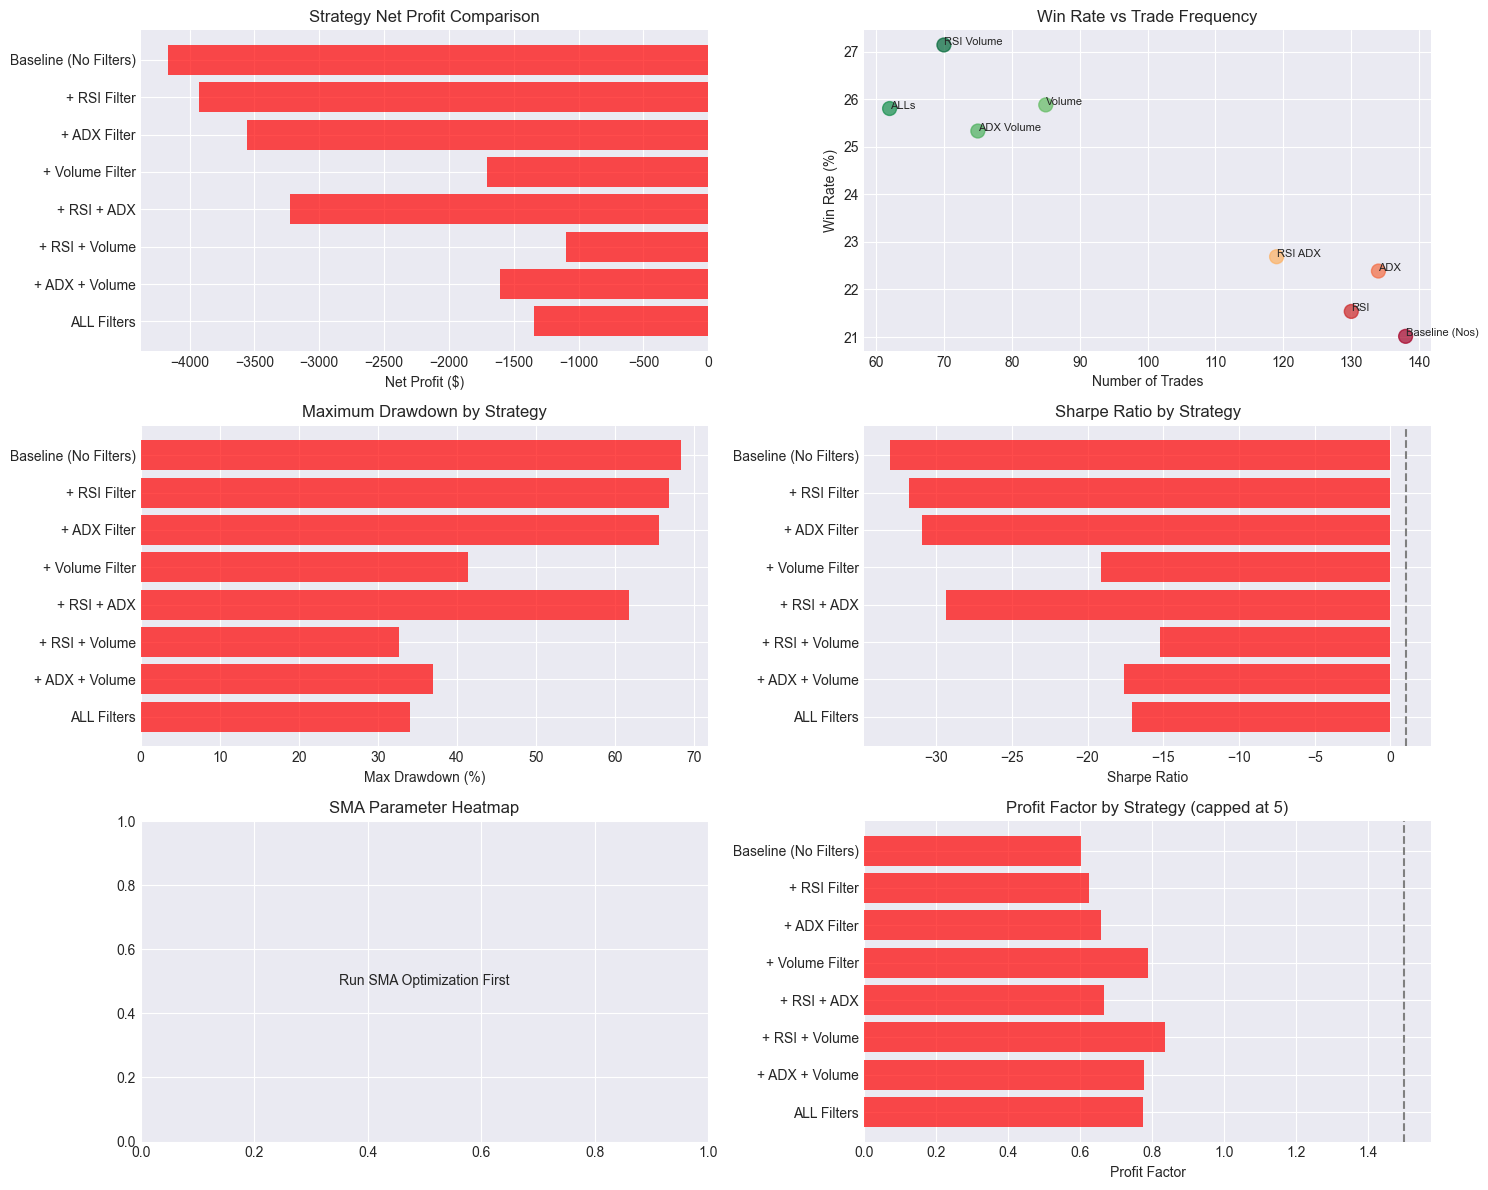


📊 CHART LEGEND:
  - Sharpe Ratio > 1: Generally good risk-adjusted returns
  - Profit Factor > 1.5: Profitable trading system
  - Win Rate + Trade Count: Quality vs Quantity tradeoff


In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create comparison charts
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# 1. Strategy Comparison - Net Profit
ax1 = axes[0, 0]
names = [r['name'] for r in filter_results]
profits = [r['net_profit'] for r in filter_results]
colors = ['green' if p > 0 else 'red' for p in profits]
ax1.barh(names, profits, color=colors, alpha=0.7)
ax1.axvline(x=0, color='black', linewidth=0.5)
ax1.set_xlabel('Net Profit ($)')
ax1.set_title('Strategy Net Profit Comparison')
ax1.invert_yaxis()

# 2. Win Rate vs Number of Trades
ax2 = axes[0, 1]
trades = [r['total_trades'] for r in filter_results]
win_rates = [r['win_rate'] * 100 for r in filter_results]
ax2.scatter(trades, win_rates, s=100, c=profits, cmap='RdYlGn', alpha=0.7)
for i, name in enumerate(names):
    ax2.annotate(name.replace('+ ', '').replace(' Filter', ''), 
                 (trades[i], win_rates[i]), fontsize=8)
ax2.set_xlabel('Number of Trades')
ax2.set_ylabel('Win Rate (%)')
ax2.set_title('Win Rate vs Trade Frequency')

# 3. Max Drawdown Comparison
ax3 = axes[1, 0]
drawdowns = [r['max_drawdown'] for r in filter_results]
colors = ['red' if d > 10 else 'orange' if d > 5 else 'green' for d in drawdowns]
ax3.barh(names, drawdowns, color=colors, alpha=0.7)
ax3.set_xlabel('Max Drawdown (%)')
ax3.set_title('Maximum Drawdown by Strategy')
ax3.invert_yaxis()

# 4. Sharpe Ratio Comparison
ax4 = axes[1, 1]
sharpes = [r['sharpe_ratio'] for r in filter_results]
colors = ['green' if s > 1 else 'orange' if s > 0 else 'red' for s in sharpes]
ax4.barh(names, sharpes, color=colors, alpha=0.7)
ax4.axvline(x=1, color='gray', linestyle='--', label='Good Sharpe (>1)')
ax4.set_xlabel('Sharpe Ratio')
ax4.set_title('Sharpe Ratio by Strategy')
ax4.invert_yaxis()

# 5. SMA Optimization Heatmap (if we have it)
ax5 = axes[2, 0]
if 'sma_results' in dir():
    pivot = pd.DataFrame(sma_results).pivot_table(
        values='net_profit', index='short_sma', columns='long_sma')
    im = ax5.imshow(pivot, cmap='RdYlGn', aspect='auto')
    ax5.set_xlabel('Long SMA Period')
    ax5.set_ylabel('Short SMA Period')
    ax5.set_title('SMA Parameter Optimization (Net Profit)')
    plt.colorbar(im, ax=ax5)
else:
    ax5.text(0.5, 0.5, 'Run SMA Optimization First', ha='center', va='center')
    ax5.set_title('SMA Parameter Heatmap')

# 6. Profit Factor Comparison
ax6 = axes[2, 1]
profit_factors = [min(r['profit_factor'], 5) for r in filter_results]  # Cap at 5 for display
colors = ['green' if pf > 1.5 else 'orange' if pf > 1 else 'red' for pf in profit_factors]
ax6.barh(names, profit_factors, color=colors, alpha=0.7)
ax6.axvline(x=1.5, color='gray', linestyle='--', label='Target PF (1.5)')
ax6.set_xlabel('Profit Factor')
ax6.set_title('Profit Factor by Strategy (capped at 5)')
ax6.invert_yaxis()

plt.tight_layout()
plt.show()

print("\n📊 CHART LEGEND:")
print("  - Sharpe Ratio > 1: Generally good risk-adjusted returns")
print("  - Profit Factor > 1.5: Profitable trading system")
print("  - Win Rate + Trade Count: Quality vs Quantity tradeoff")

## 9. Data-Driven Recommendations

In [10]:
# Generate data-driven recommendations based on backtest results

print("="*80)
print("📋 RESEARCH FINDINGS & RECOMMENDATIONS")
print("="*80)

# Analyze baseline performance
baseline = filter_results[0]  # First result is baseline
best = best_filter

print("\n🔍 CURRENT STRATEGY ANALYSIS (SMA 10/30):")
print(f"  • Total Trades: {baseline['total_trades']}")
print(f"  • Win Rate: {baseline['win_rate']:.1%}")
print(f"  • Net Profit: ${baseline['net_profit']:.2f}")
print(f"  • Max Drawdown: {baseline['max_drawdown']:.1f}%")
print(f"  • Sharpe Ratio: {baseline['sharpe_ratio']:.2f}")
pf_base = baseline['profit_factor'] if baseline['profit_factor'] != float('inf') else 999
print(f"  • Profit Factor: {pf_base:.2f}")

print("\n🏆 BEST TESTED COMBINATION:")
print(f"  • Strategy: {best['name']}")
print(f"  • Total Trades: {best['total_trades']}")
print(f"  • Win Rate: {best['win_rate']:.1%}")
print(f"  • Net Profit: ${best['net_profit']:.2f}")
print(f"  • Max Drawdown: {best['max_drawdown']:.1f}%")
print(f"  • Sharpe Ratio: {best['sharpe_ratio']:.2f}")

# Calculate improvement
profit_improvement = ((best['net_profit'] - baseline['net_profit']) / abs(baseline['net_profit']) * 100) if baseline['net_profit'] != 0 else 0
dd_improvement = baseline['max_drawdown'] - best['max_drawdown']

print(f"\n📈 IMPROVEMENT vs BASELINE:")
if best['net_profit'] > baseline['net_profit']:
    print(f"  • Profit: +{profit_improvement:.1f}% (${best['net_profit'] - baseline['net_profit']:.2f})")
else:
    print(f"  • Profit: {profit_improvement:.1f}% (${best['net_profit'] - baseline['net_profit']:.2f})")
print(f"  • Drawdown: {'-' if dd_improvement > 0 else '+'}{abs(dd_improvement):.1f}%")
print(f"  • Win Rate: {'+' if best['win_rate'] > baseline['win_rate'] else ''}{(best['win_rate'] - baseline['win_rate'])*100:.1f}%")

# Generate specific recommendations
print("\n" + "="*80)
print("💡 RECOMMENDED IMPROVEMENTS FOR JULABA:")
print("="*80)

recommendations = []

# Check if ADX filter improved results
adx_results = [r for r in filter_results if 'ADX' in r['name']]
if adx_results:
    best_adx = max(adx_results, key=lambda x: x['net_profit'])
    if best_adx['net_profit'] > baseline['net_profit']:
        recommendations.append({
            'priority': 'HIGH',
            'change': 'Add ADX Trend Filter',
            'description': 'Only trade when ADX > 20 (trend is present)',
            'expected': f"+{((best_adx['net_profit'] - baseline['net_profit'])/abs(baseline['net_profit'])*100):.0f}% profit" if baseline['net_profit'] != 0 else "Improved profit",
            'code_file': 'indicator.py'
        })

# Check if RSI filter improved results  
rsi_results = [r for r in filter_results if 'RSI' in r['name'] and 'ADX' not in r['name'] and 'Volume' not in r['name']]
if rsi_results:
    best_rsi = max(rsi_results, key=lambda x: x['net_profit'])
    if best_rsi['win_rate'] > baseline['win_rate']:
        recommendations.append({
            'priority': 'MEDIUM',
            'change': 'Add RSI Filter',
            'description': 'Skip long if RSI > 70, skip short if RSI < 30',
            'expected': f"+{(best_rsi['win_rate'] - baseline['win_rate'])*100:.0f}% win rate",
            'code_file': 'indicator.py'
        })

# Check volume filter
vol_results = [r for r in filter_results if 'Volume' in r['name'] and 'RSI' not in r['name'] and 'ADX' not in r['name']]
if vol_results:
    best_vol = max(vol_results, key=lambda x: x['win_rate'])
    if best_vol['win_rate'] > baseline['win_rate']:
        recommendations.append({
            'priority': 'MEDIUM',
            'change': 'Add Volume Confirmation',
            'description': 'Only trade when volume > 20-period average',
            'expected': 'Better signal confirmation',
            'code_file': 'indicator.py'
        })

# SMA optimization recommendation
if 'best_sma_result' in dir() and best_sma_result:
    if (best_sma_result['short_sma'] != 10 or best_sma_result['long_sma'] != 30):
        recommendations.append({
            'priority': 'HIGH',
            'change': f"Optimize SMA to {best_sma_result['short_sma']}/{best_sma_result['long_sma']}",
            'description': f"Change from 10/30 to {best_sma_result['short_sma']}/{best_sma_result['long_sma']}",
            'expected': f"Better crossover timing",
            'code_file': 'bot.py'
        })

# Check max drawdown - if too high, suggest tighter stops
if baseline['max_drawdown'] > 15:
    recommendations.append({
        'priority': 'HIGH',
        'change': 'Reduce Position Size or Stop Loss',
        'description': f'Max DD of {baseline["max_drawdown"]:.1f}% is high. Consider 1.5x ATR stops or 1.5% risk.',
        'expected': 'Lower drawdowns, more sustainable',
        'code_file': 'bot.py'
    })

# Always recommend trailing stop improvement
recommendations.append({
    'priority': 'MEDIUM',
    'change': 'Tighter Trailing Stops After TP1',
    'description': 'After TP1 hit, trail at 1x ATR instead of 1.5x ATR',
    'expected': 'Lock in more profits',
    'code_file': 'bot.py'
})

# Print recommendations
for i, rec in enumerate(recommendations, 1):
    print(f"\n{i}. [{rec['priority']}] {rec['change']}")
    print(f"   📝 {rec['description']}")
    print(f"   📈 Expected: {rec['expected']}")
    print(f"   📁 File: {rec['code_file']}")

print("\n" + "="*80)
print("⚠️  IMPORTANT NOTES:")
print("="*80)
print("• These results are based on historical data - past performance ≠ future results")
print("• Test any changes in paper trading before going live")
print("• Market conditions change - re-run this analysis monthly")
print("• The AI filter in Julaba adds additional context not captured here")

📋 RESEARCH FINDINGS & RECOMMENDATIONS

🔍 CURRENT STRATEGY ANALYSIS (SMA 10/30):
  • Total Trades: 138
  • Win Rate: 21.0%
  • Net Profit: $-4167.74
  • Max Drawdown: 68.4%
  • Sharpe Ratio: -33.07
  • Profit Factor: 0.60

🏆 BEST TESTED COMBINATION:
  • Strategy: + RSI + Volume
  • Total Trades: 70
  • Win Rate: 27.1%
  • Net Profit: $-1097.84
  • Max Drawdown: 32.7%
  • Sharpe Ratio: -15.19

📈 IMPROVEMENT vs BASELINE:
  • Profit: +73.7% ($3069.90)
  • Drawdown: -35.7%
  • Win Rate: +6.1%

💡 RECOMMENDED IMPROVEMENTS FOR JULABA:

1. [HIGH] Add ADX Trend Filter
   📝 Only trade when ADX > 20 (trend is present)
   📈 Expected: +61% profit
   📁 File: indicator.py

2. [MEDIUM] Add RSI Filter
   📝 Skip long if RSI > 70, skip short if RSI < 30
   📈 Expected: +1% win rate
   📁 File: indicator.py

3. [MEDIUM] Add Volume Confirmation
   📝 Only trade when volume > 20-period average
   📈 Expected: Better signal confirmation
   📁 File: indicator.py

4. [HIGH] Reduce Position Size or Stop Loss
   📝 Max

## 10. Summary Statistics Export

Export findings to a JSON file for future reference and comparison.

In [ ]:
import json
from datetime import datetime

# Create summary report
summary = {
    'generated_at': datetime.now().isoformat(),
    'symbol': 'LINK/USDT',
    'timeframe': '1m',
    'data_range': f"{len(df)} candles",
    'initial_balance': backtester.initial_balance,
    'baseline_strategy': {
        'name': 'SMA 10/30 Crossover',
        'trades': baseline['total_trades'],
        'win_rate': round(baseline['win_rate'] * 100, 1),
        'net_profit': round(baseline['net_profit'], 2),
        'max_drawdown': round(baseline['max_drawdown'], 1),
        'sharpe_ratio': round(baseline['sharpe_ratio'], 2)
    },
    'best_strategy': {
        'name': best['name'],
        'trades': best['total_trades'],
        'win_rate': round(best['win_rate'] * 100, 1),
        'net_profit': round(best['net_profit'], 2),
        'max_drawdown': round(best['max_drawdown'], 1),
        'sharpe_ratio': round(best['sharpe_ratio'], 2)
    },
    'all_results': [
        {
            'name': r['name'],
            'trades': r['total_trades'],
            'win_rate': round(r['win_rate'] * 100, 1),
            'net_profit': round(r['net_profit'], 2),
            'max_drawdown': round(r['max_drawdown'], 1),
            'sharpe_ratio': round(r['sharpe_ratio'], 2),
            'profit_factor': round(min(r['profit_factor'], 999), 2)
        }
        for r in filter_results
    ],
    'recommendations': [
        {'priority': rec['priority'], 'change': rec['change'], 'file': rec['code_file']}
        for rec in recommendations
    ]
}

# Save to file
with open('strategy_research_results.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("✅ Research results saved to: strategy_research_results.json")
print(f"\n📊 Research completed at: {summary['generated_at']}")
print(f"📈 Best Strategy Found: {best['name']} (${best['net_profit']:.2f} profit)")
print(f"📝 {len(recommendations)} improvement recommendations generated")

NameError: name 'symbol' is not defined